In [1]:
# Defining Libraries:

import mne
import numpy as np
from scipy.signal import welch, stft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder
import torch
import seaborn as sns
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from itertools import cycle
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [2]:
# Defining File Paths:

file_participant_1 = 'Data/Participant_1.edf'
file_participant_2 = 'Data/Participant_2.edf'
file_participant_3 = 'Data/Participant_3.edf'
file_participant_4 = 'Data/Participant_4.edf'
file_participant_5 = 'Data/Participant_5.edf'
file_participant_6 = 'Data/Participant_6.edf'
file_participant_7 = 'Data/Participant_7.edf'
file_participant_8 = 'Data/Participant_8.edf'
file_participant_9 = 'Data/Participant_9.edf'
file_participant_10 = 'Data/Participant_10.edf'
file_participant_11 = 'Data/Participant_11.edf'
file_participant_12 = 'Data/Participant_12.edf'
file_participant_13 = 'Data/Participant_13.edf'

edf_data_files = [
    file_participant_1,
    file_participant_2,
    file_participant_3,
    file_participant_4,
    file_participant_5,
    file_participant_6,
    file_participant_7,
    file_participant_8,
    file_participant_9,
    file_participant_10,
    file_participant_11,
    file_participant_12,
    file_participant_13
]

In [3]:
# Remove Start, Finish and Breaks:

# Loading the first file to use as a reference for channel names:
reference_raw = mne.io.read_raw_edf(edf_data_files[0], preload = True)
reference_channels = reference_raw.info['ch_names']

raw_objects = []

# Define the segments of interest in seconds:
segments = [
    (30, 90),  # "I"
    (120, 180),  # "Yes"
    (210, 270),  # "No"
    (300, 360),  # "Want"
    (390, 450),  # "Help"
    (480, 540),  # "More"
    (570, 630),  # "That"
    (660, 720),  # "Stop"
    (750, 810),  # "Open"
    (840, 900)   # "Close"
]

for file_path in edf_data_files:
    print(f"Editing file: {file_path}...")
    raw = mne.io.read_raw_edf(file_path, preload = True)
    raw.pick_channels(reference_channels)
    
    # Create an empty list to store the segments:
    data_segments = []
    
    for start, end in segments:
        segment = raw.copy().crop(tmin = start, tmax = end)
        data_segments.append(segment)
    
    # Concatenate the segments:
    raw_concatenated = mne.concatenate_raws(data_segments)
    raw_objects.append(raw_concatenated)

Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117759  =      0.000 ...   919.992 secs...
Editing file: Data/Participant_1.edf...
Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117759  =      0.000 ...   919.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Editing file: Data/Participant_2.edf...
Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 116479  =      0.000 ...   909.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Editing file:

In [4]:
# Displaying the Resulting Files after Segmentation:

raw_objects

[<RawEDF | Participant_1.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_2.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_3.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_4.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_5.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_6.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_7.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_8.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_9.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_10.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_11.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_12.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_13.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>]

In [5]:
# Concatenating all Loaded and Processed Files:

raw = mne.concatenate_raws(raw_objects)

In [6]:
# Function to Preprocess Raw Data:

def preprocess_raw_data(raw):

    print("STARTING PREPROCESSING: ")

    # Handling NaNs: Replace NaNs with the mean of the respective channel:
    raw_data = raw.get_data()

    for i in range(raw_data.shape[0]):
        nan_indices = np.isnan(raw_data[i])

        if np.any(nan_indices):
            mean_value = np.nanmean(raw_data[i])
            raw_data[i, nan_indices] = mean_value

    raw._data = raw_data

    print("\n")

    # Filtering: Bandpass filter between 4-30 Hz:
    raw.filter(4., 30., fir_design = 'firwin')

    print("\n")
    
    # Artifact Removal: Independent Component Analysis (ICA):
    ica = mne.preprocessing.ICA(n_components = 14, random_state = 97, max_iter = 800)
    ica.fit(raw)
    raw = ica.apply(raw)

    print("\n")
    
    # Spatial Filtering: Common Average Reference (CAR):
    raw.set_eeg_reference('average', projection = True)

    print("\n")
    
    # Channel Interpolation: Interpolate bad channels
    raw.interpolate_bads()

    print("\n")

    # Baseline Correction: Apply baseline correction using the mean of the segment
    raw.apply_function(lambda x: x - np.mean(x), picks = 'eeg')

    print("\n")
    print("PREPROCESSING DONE!")
    
    return raw

In [7]:
# Preprocessing the Raw Data:

raw = preprocess_raw_data(raw)

STARTING PREPROCESSING: 


Filtering raw data in 130 contiguous segments
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 213 samples (1.664 s)



Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 14 components
Fitting ICA took 10.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 60 PCA components


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Setting channel interpolation method to {'eeg': 'spline'}.




PREPROCESSING DONE!


C:\Users\salib\AppData\Local\Temp\ipykernel_21364\1246034114.py:39: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


In [8]:
# Creating Fixed-Length Epochs:

epoch_duration = 60  # seconds
start_times = np.arange(0, raw.times[-1] - epoch_duration, epoch_duration)
end_times = start_times + epoch_duration

In [9]:
# Displaying Epoch Start and End Times:

print("Start Times: ", start_times)
print("\nTotal Number of Start Times: ", len(start_times))
print("\n")
print("End Times: ", end_times)
print("\nTotal Number of End Times: ", len(end_times))

Start Times:  [   0.   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.
  720.  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380.
 1440. 1500. 1560. 1620. 1680. 1740. 1800. 1860. 1920. 1980. 2040. 2100.
 2160. 2220. 2280. 2340. 2400. 2460. 2520. 2580. 2640. 2700. 2760. 2820.
 2880. 2940. 3000. 3060. 3120. 3180. 3240. 3300. 3360. 3420. 3480. 3540.
 3600. 3660. 3720. 3780. 3840. 3900. 3960. 4020. 4080. 4140. 4200. 4260.
 4320. 4380. 4440. 4500. 4560. 4620. 4680. 4740. 4800. 4860. 4920. 4980.
 5040. 5100. 5160. 5220. 5280. 5340. 5400. 5460. 5520. 5580. 5640. 5700.
 5760. 5820. 5880. 5940. 6000. 6060. 6120. 6180. 6240. 6300. 6360. 6420.
 6480. 6540. 6600. 6660. 6720. 6780. 6840. 6900. 6960. 7020. 7080. 7140.
 7200. 7260. 7320. 7380. 7440. 7500. 7560. 7620. 7680. 7740.]

Total Number of Start Times:  130


End Times:  [  60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.  720.
  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380. 1440.

In [10]:
# Defining the Words:

words = ['I', 'Yes', 'No', 'Want', 'Help', 'More', 'That', 'Stop', 'Open', 'Close']
print("Words: ", words)

Words:  ['I', 'Yes', 'No', 'Want', 'Help', 'More', 'That', 'Stop', 'Open', 'Close']


In [11]:
# Defining the Frequency:

sfreq = raw.info['sfreq']
print("Frequency Across Channels: ", sfreq, "Hz")

Frequency Across Channels:  128.0 Hz


In [12]:
# Feature Extraction Function:

def extract_features(epoch_data, sfreq):

    # Power Spectral Density (PSD) Features:
    freqs, psd = welch(epoch_data, sfreq, nperseg = int(sfreq)) # Compute PSD using Welch’s method.
    # Average power in the theta (4-8 Hz), alpha (8-12 Hz), and beta (12-30 Hz) frequency bands:
    theta_power = psd[:, (freqs > 4) & (freqs <= 8)].mean(axis = 1)
    alpha_power = psd[:, (freqs > 8) & (freqs <= 12)].mean(axis = 1)
    beta_power = psd[:, (freqs > 12) & (freqs <= 30)].mean(axis = 1)

    # Short-Time Fourier Transform (STFT) Features:
    _, _, Zxx = stft(epoch_data, fs = sfreq, nperseg = int(sfreq/2)) # Computes STFT.
    stft_power = np.abs(Zxx).mean(axis = 2) # Mean power from the STFT representation, averaged over time.
    
    # Combining Features into a single array with each feature as a column:
    features = np.stack([
        theta_power,
        alpha_power,
        beta_power,
        stft_power.mean(axis = 1)
    ], axis = 1) 

    return features

In [13]:
# Segmenting the Data into Epochs and Sub-Epochs:
# First -> 60 second epochs.
# Second -> 2 second sub-epochs.
# Third -> Extracting Features.

labeled_features_data = []
sub_epoch_duration = 2  # seconds

# Initialize counters
num_epochs = 0
num_sub_epochs = 0

for i, (start, end) in enumerate(zip(start_times, end_times)): # Loops through each 60-second epoch:
    start_sample = int(start * sfreq)
    end_sample = int(end * sfreq)
    epoch_data, _ = raw[:, start_sample:end_sample] # Extracts the EEG data for the current epoch.
    word_label = words[i % len(words)] # Assigns a label to the current epoch using a list of predefined words.

    num_epochs += 1 # Increment epoch counter
    
    for j in range(int(epoch_duration / sub_epoch_duration)): # Iterate over Sub-Epochs:
        sub_start = j * sub_epoch_duration * int(sfreq)
        sub_end = (j + 1) * sub_epoch_duration * int(sfreq)
        sub_epoch_data = epoch_data[:, sub_start:sub_end]
        
        # Calls the extract_features function to extract from sub-epoch:
        features = extract_features(sub_epoch_data, sfreq)
        labeled_features_data.append((features, word_label)) # Stores the extracted features along with the label.

        num_sub_epochs += 1 # Increment sub-epoch counter

In [14]:
# Output the number of epochs and sub-epochs
print(f"Total number of epochs: {num_epochs}")
print(f"Total number of sub-epochs: {num_sub_epochs}")

Total number of epochs: 130
Total number of sub-epochs: 3900


In [15]:
# Extracting Features and Labels:

features = np.array([f[0] for f in labeled_features_data])
labels = np.array([f[1] for f in labeled_features_data])

In [16]:
len(features)

3900

In [17]:
len(labels)

3900

In [18]:
labels

array(['I', 'I', 'I', ..., 'Close', 'Close', 'Close'], dtype='<U5')

In [19]:
# Preparing Data - Flattening & Scaling:

# Flattening the last two dimensions of the features array:
# To transform the 3D feature array into a 2D array where each row represents a single sample and each column represents a feature.
flattened_features = features.reshape(features.shape[0], -1)

# Scaling the features:
# To standardise the features by scaling them so that they have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(flattened_features)

In [20]:
# Feature Selection Based on Mutual Information:

num_features = scaled_features.shape[1]
k_best = min(num_features, 75)  
mi_selector = SelectKBest(mutual_info_classif, k = k_best)
features_mi = mi_selector.fit_transform(scaled_features, labels)
selected_features = features_mi 
num_features_mi = features_mi.shape[1]  

In [21]:
num_features_mi

75

In [22]:
num_features

240

In [23]:
k_best

75

In [24]:
# Creating Train, Test and Validation Sets (80, 10, 10):

train_features, test_features, train_labels, test_labels = train_test_split(
    selected_features, labels, test_size = 0.2, random_state = 42, stratify = labels)

val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size = 0.5, random_state = 42, stratify = test_labels)

In [25]:
# Displaying Dataset Distribution:

print(f"Training: {len(train_features)}")
print(f"Validation: {len(val_features)}")
print(f"Testing: {len(test_features)}")

Training: 3120
Validation: 390
Testing: 390


In [26]:
# Designing Training Dataset:

class EEGDataset(Dataset):

    def __init__(self, features, labels):

        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.long)
    
    def __len__(self):

        features_len = len(self.features)
        return features_len
    
    def __getitem__(self, idx):

        feat = self.features[idx]
        labels = self.labels[idx]
        return feat, labels 

In [27]:
# String -> Integers for Training:

label_encoder = LabelEncoder()
train_dataset = EEGDataset(train_features, label_encoder.fit_transform(train_labels))
val_dataset = EEGDataset(val_features, label_encoder.transform(val_labels))
test_dataset = EEGDataset(test_features, label_encoder.transform(test_labels))

# Print each label and its equivalent encoded label:
for label, encoded_label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f'Label: {label}, Encoded: {encoded_label}')

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 256)
test_loader = DataLoader(test_dataset, batch_size = 256)

Label: Close, Encoded: 0
Label: Help, Encoded: 1
Label: I, Encoded: 2
Label: More, Encoded: 3
Label: No, Encoded: 4
Label: Open, Encoded: 5
Label: Stop, Encoded: 6
Label: That, Encoded: 7
Label: Want, Encoded: 8
Label: Yes, Encoded: 9


In [28]:
# Define the Transformer Model:

class TransformerModel(nn.Module):
    def __init__(self, feature_dim, num_labels, model_dim = 256, num_heads = 8, encoder_layers = 16, ff_dim = 512, dropout_prob = 0.1, noise_level = 0.01):

        super(TransformerModel, self).__init__()
        self.noise_level = noise_level # Initialise noise level for input data augmentation.
        self.input_projection = nn.Linear(feature_dim, model_dim) # Linear layer to project input features to model dimension.
        self.input_dropout = nn.Dropout(dropout_prob) # Dropout for input projection layer.
        
        # Define a single transformer encoder layer with pre-LayerNorm (Dimensionality of the model, Number of attention heads, Dimension of the feedforward network, Dropout probability, Activation function, pre-layer normalisation):
        encoder_layer = TransformerEncoderLayer(d_model = model_dim, nhead = num_heads, dim_feedforward = ff_dim, dropout = dropout_prob, activation = 'gelu', norm_first = True)

        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers = encoder_layers) # Stack multiple transformer encoder layers.
        self.batch_norm = nn.BatchNorm1d(model_dim) # Batch normalisation layer for transformer output.
        self.output_projection = nn.Linear(model_dim, num_labels) # Linear layer to project transformer output to the number of classes.
        self.output_dropout = nn.Dropout(dropout_prob) # Dropout for output projection layer.

    def forward(self, inputs):

        # Apply noise to inputs during training for regularisation:
        if self.training and self.noise_level > 0.0:
            noise = torch.randn_like(inputs) * self.noise_level
            inputs = inputs + noise

        inputs = self.input_projection(inputs) # Project inputs to the model dimension.
        inputs = self.input_dropout(inputs) # Apply dropout to the projected inputs.
        inputs = self.transformer_encoder(inputs) # Project inputs to the model dimension.
        inputs = self.batch_norm(inputs) # Apply batch normalisation to the transformer outputs.
        inputs = self.output_dropout(inputs) # Apply dropout to the transformer outputs.
        inputs = self.output_projection(inputs) # Project the normalised outputs to the number of classes.

        return F.log_softmax(inputs, dim = 1) # Return the log-softmax of the output projections.

In [29]:
# Transformer Architecture:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(feature_dim = train_features.shape[1], num_labels = len(np.unique(train_labels))).to(device)

print(model)

TransformerModel(
  (input_projection): Linear(in_features=75, out_features=256, bias=True)
  (input_dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-15): 16 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_projection): Linear(in_features=2

c:\Users\salib\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [30]:
# Training with Early Stopping and with Accuracy and Loss over Epochs:

# Hyperparameters for Training:
epochs = 1500 # Number of epochs to train the model.
l1_lambda = 0.0001 # Lambda for L1 regularisation.
#l1_lambda = 0.001
train_accuracies = [] # List to store training accuracies for each epoch.
val_accuracies = [] # List to store validation accuracies for each epoch.
train_losses = [] # List to store training losses for each epoch.
val_losses = [] # List to store validation losses for each epoch.

# Early stopping parameters
patience = 30
best_val_loss = np.inf
patience_counter = 0

# Loss Function and Optimiser:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, weight_decay = 1e-8)

# Training Loop:
for epoch in range(epochs):

    # Initialisation:
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    all_train_labels = [] 
    all_train_preds = [] 

    # Iterate over the training data loader:
    for features, labels in train_loader:

        features, labels = features.to(device), labels.to(device) 
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, labels)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm  # L1 regularization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        predictions = torch.max(output, 1)[1]
        train_correct += (predictions == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy()) #Added this
        all_train_preds.extend(predictions.cpu().numpy()) #Added this

    train_accuracy = train_correct / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss / total_train) # Add train loss

    # Validation:
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    all_val_labels = [] 
    all_val_preds = [] 

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            output = model(features)
            loss = criterion(output, labels)
            val_loss += loss.item()
            predictions = torch.max(output, 1)[1]
            val_correct += (predictions == labels).sum().item()
            total_val += labels.size(0)

            all_val_labels.extend(labels.cpu().numpy()) #Added this
            all_val_preds.extend(predictions.cpu().numpy()) #Added this

    val_accuracy = val_correct / total_val
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss / total_val) # Add validation loss

    # Print the training and validation metrics for the current epoch:
    print(f'Epoch {epoch+1}, Loss: {train_loss / total_train}, Training Accuracy: {train_accuracy}, '
          f'Validation Loss: {val_loss / total_val}, Validation Accuracy: {val_accuracy}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'Phase_1/Final_Models/CNN_Model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Epoch 1, Loss: 0.12474853381132468, Training Accuracy: 0.10128205128205128, Validation Loss: 0.013689332130627754, Validation Accuracy: 0.09230769230769231
Epoch 2, Loss: 0.124295668112926, Training Accuracy: 0.11826923076923077, Validation Loss: 0.01216141077188345, Validation Accuracy: 0.09230769230769231
Epoch 3, Loss: 0.12386954319782746, Training Accuracy: 0.11858974358974358, Validation Loss: 0.011967031160990398, Validation Accuracy: 0.13333333333333333
Epoch 4, Loss: 0.12354205204890324, Training Accuracy: 0.14198717948717948, Validation Loss: 0.011823065464313214, Validation Accuracy: 0.14102564102564102
Epoch 5, Loss: 0.12318782684130547, Training Accuracy: 0.15, Validation Loss: 0.011675289961007924, Validation Accuracy: 0.14358974358974358
Epoch 6, Loss: 0.12290612917680006, Training Accuracy: 0.15737179487179487, Validation Loss: 0.011583674871004545, Validation Accuracy: 0.17435897435897435
Epoch 7, Loss: 0.12259290034954365, Training Accuracy: 0.16826923076923078, Valida

In [31]:
# Save the Trained Model:

model_path = 'Phase_1/Final_Models/Transformer_Model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to Phase_1/Final_Models/Transformer_Model.pth


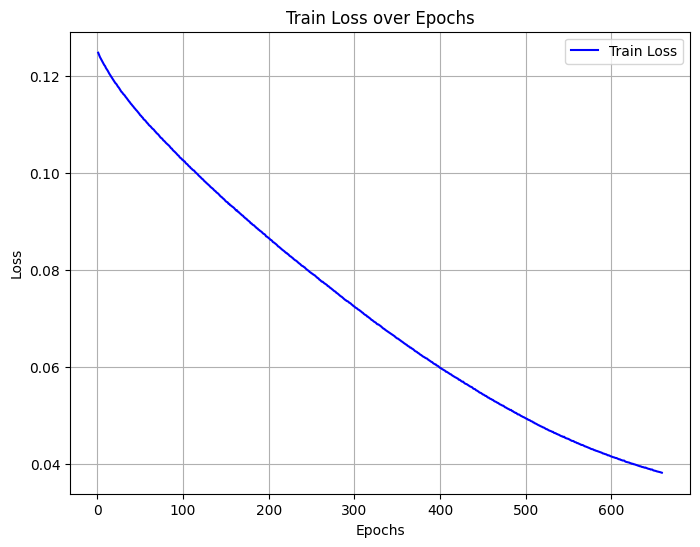

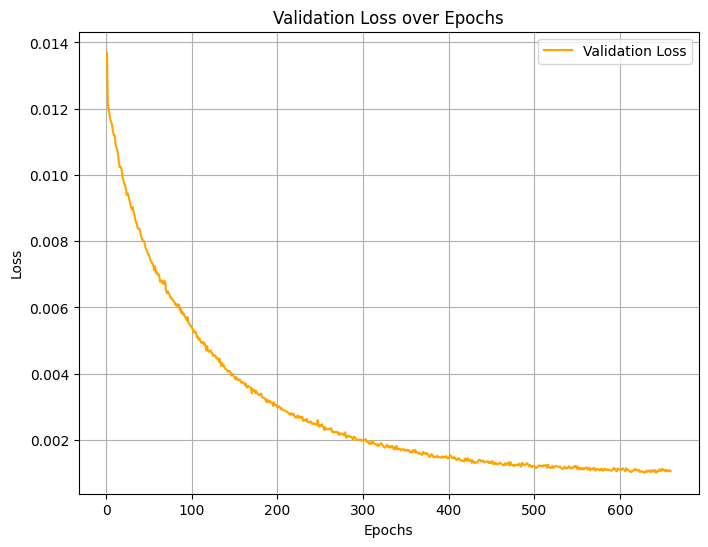

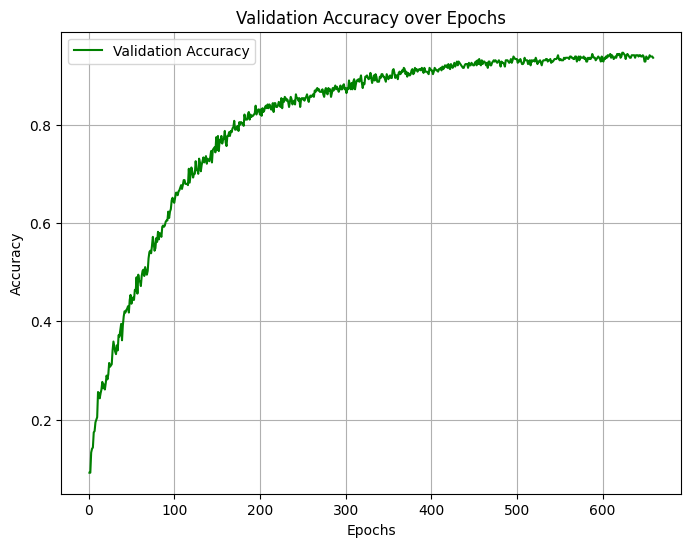

In [32]:
# Training and Validation Loss:

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs_range, train_losses, label = 'Train Loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(epochs_range, val_losses, label = 'Validation Loss', color = 'orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy:
plt.figure(figsize = (8, 6))
plt.plot(epochs_range, val_accuracies, label = 'Validation Accuracy', color = 'green')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluation Function:

def calculate_metrics(labels, preds, dataset_name):

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average = 'weighted')
    recall = recall_score(labels, preds, average = 'weighted')
    f1 = f1_score(labels, preds, average = 'weighted')
    class_report = classification_report(labels, preds)
    conf_matrix = confusion_matrix(labels, preds)
    std_dev = np.std(preds)
    kappa = cohen_kappa_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)

    # Binarize the labels for ROC curve calculation
    n_classes = 10
    labels_binarized = label_binarize(labels, classes = range(n_classes))
    preds_binarized = label_binarize(preds, classes = range(n_classes))

    # Compute ROC curve and ROC area for each class:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], preds_binarized[:, i])
        roc_auc[i] = roc_auc_score(labels_binarized[:, i], preds_binarized[:, i])

     # Compute Precision-Recall curve and PR area for each class:
    precision_curve = dict()
    recall_curve = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision_curve[i], recall_curve[i], _ = precision_recall_curve(labels_binarized[:, i], preds_binarized[:, i])
        average_precision[i] = average_precision_score(labels_binarized[:, i], preds_binarized[:, i])

    print(f'---------- {dataset_name} Evaluation Metrics: ----------\n')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print("\n")

    print(f'Cohen\'s Kappa: {kappa:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print("\n")

    print('Classification Report:')
    print(class_report)
    print("\n")

    print('Confusion Matrix:')
    print("\n")
    plt.figure(figsize = (10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Blues', xticklabels = words, yticklabels = words)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    print(f'Standard Deviation: {std_dev:.4f}\n')

    print("ROC Curve and AUC Scores: ")
    # Plot ROC curve
    plt.figure(figsize = (10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color = color, lw = 2,
                 label = f'ROC curve of class {words[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve')
    plt.legend(loc = "lower right")
    plt.show()

    print("Precision-Recall Curve: ")
    # Plot Precision-Recall curve
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall_curve[i], precision_curve[i], color = color, lw = 2,
                 label=f'PR curve of class {words[i]} (area = {average_precision[i]:0.2f})')

    plt.plot([0, 1], [1, 0], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.legend(loc = "lower left")
    plt.show()

---------- Training Evaluation Metrics: ----------

Accuracy: 0.9619
Precision: 0.9619
Recall: 0.9619
F1-score: 0.9618


Cohen's Kappa: 0.9576
Matthews Correlation Coefficient: 0.9576


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       312
           1       0.96      0.97      0.96       312
           2       0.97      0.98      0.98       312
           3       0.97      0.96      0.96       312
           4       0.96      0.96      0.96       312
           5       0.96      0.94      0.95       312
           6       0.94      0.94      0.94       312
           7       0.96      0.97      0.97       312
           8       0.96      0.95      0.95       312
           9       0.96      0.96      0.96       312

    accuracy                           0.96      3120
   macro avg       0.96      0.96      0.96      3120
weighted avg       0.96      0.96      0.96      3120



Confusion Matrix:




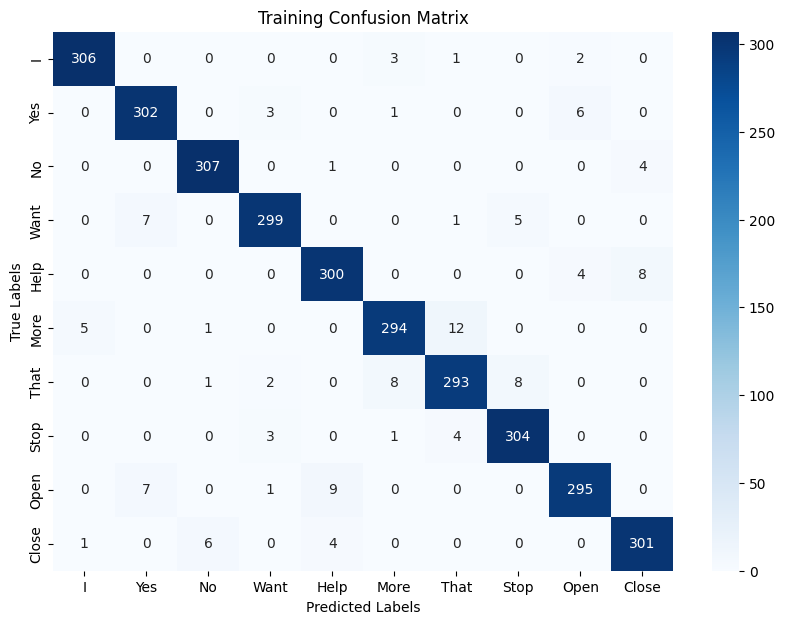

Standard Deviation: 2.8748

ROC Curve and AUC Scores: 


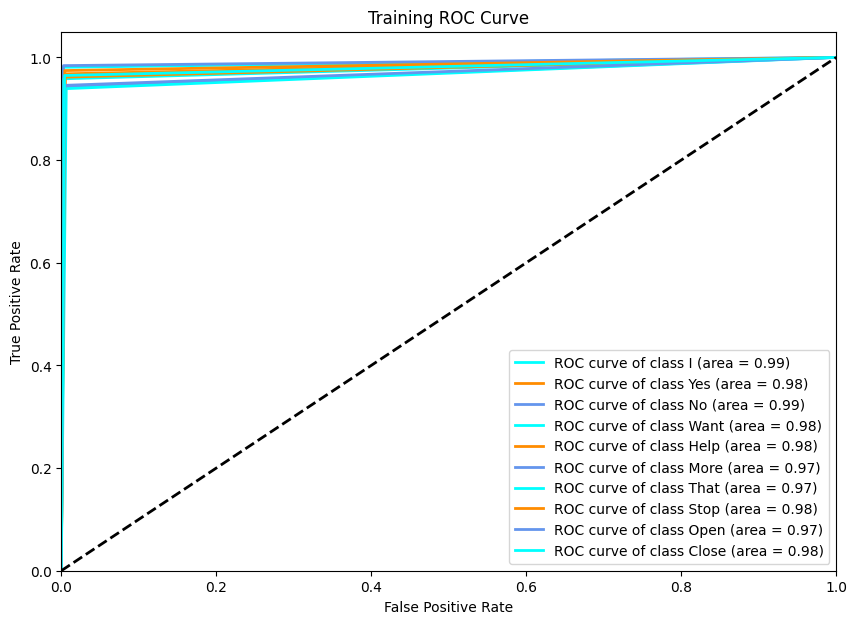

Precision-Recall Curve: 


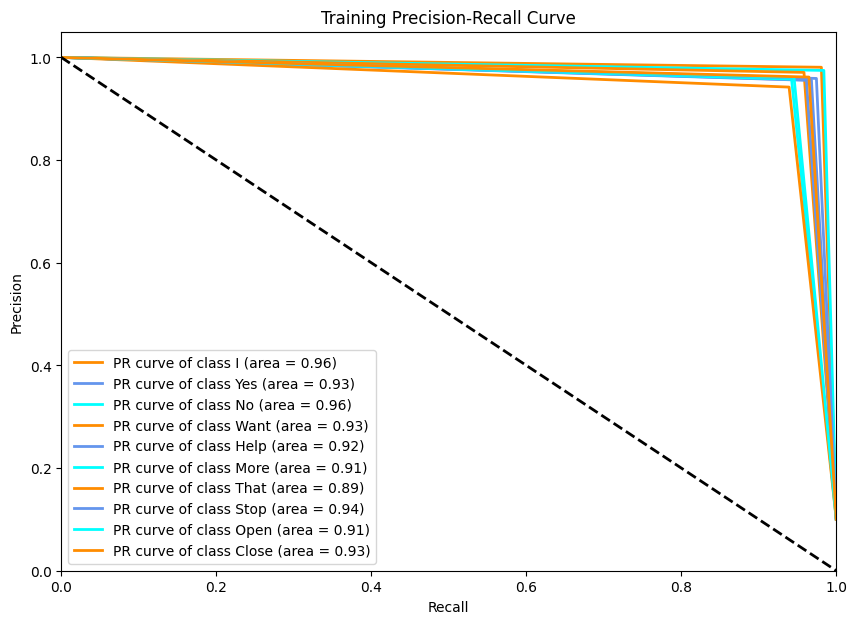

---------- Validation Evaluation Metrics: ----------

Accuracy: 0.9359
Precision: 0.9363
Recall: 0.9359
F1-score: 0.9360


Cohen's Kappa: 0.9288
Matthews Correlation Coefficient: 0.9288


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.93      0.95      0.94        39
           2       0.97      1.00      0.99        39
           3       0.95      0.92      0.94        39
           4       0.95      0.90      0.92        39
           5       0.88      0.90      0.89        39
           6       0.88      0.90      0.89        39
           7       0.97      0.95      0.96        39
           8       0.92      0.92      0.92        39
           9       0.97      0.97      0.97        39

    accuracy                           0.94       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



Confusion Matrix:




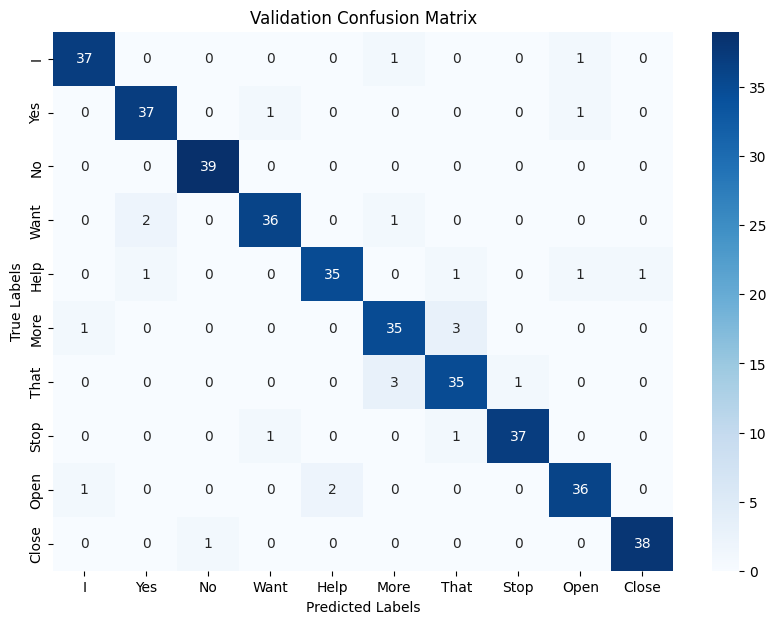

Standard Deviation: 2.8776

ROC Curve and AUC Scores: 


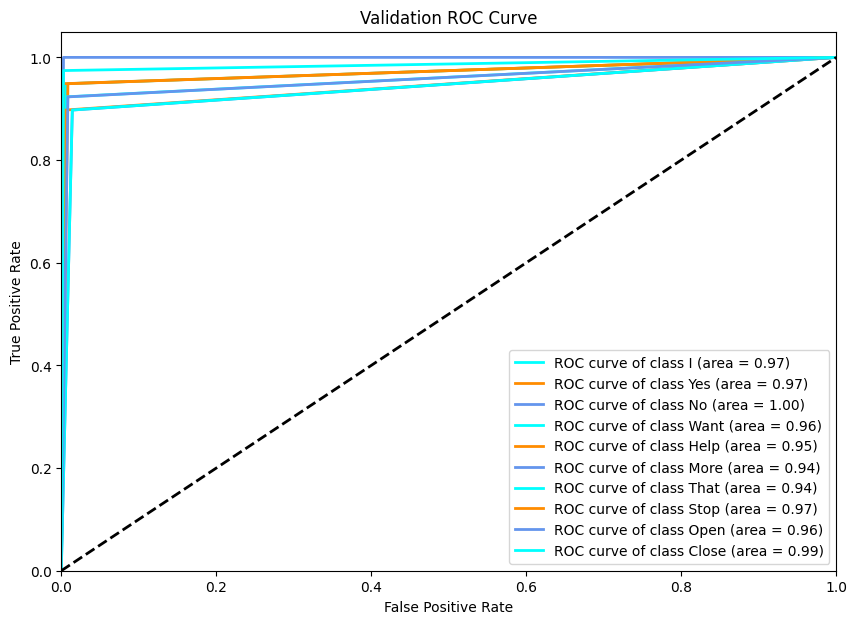

Precision-Recall Curve: 


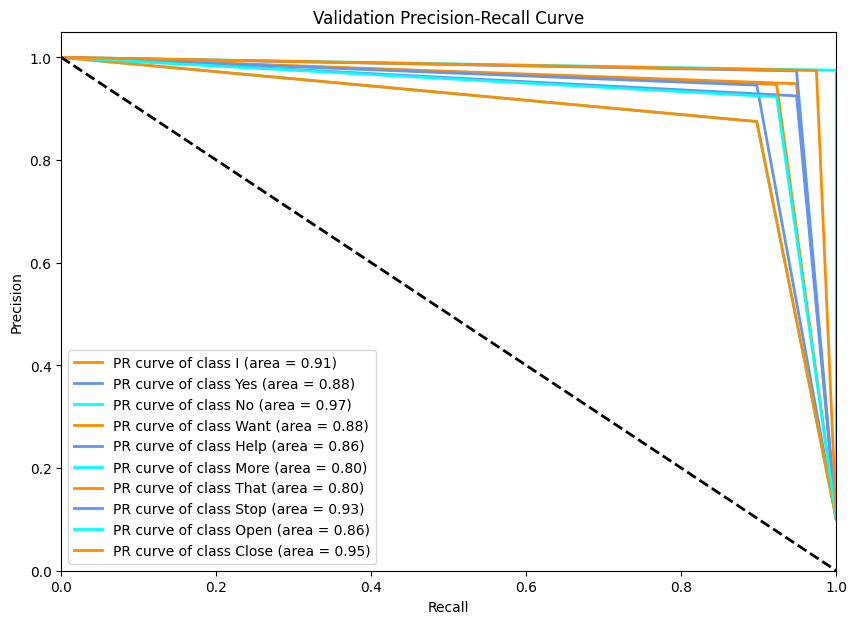

In [34]:
# Calculate metrics for the Training and Validation Sets:

calculate_metrics(all_train_labels, all_train_preds, dataset_name = f'Training')
calculate_metrics(all_val_labels, all_val_preds, dataset_name = f'Validation')

---------- Test Set Evaluation Metrics: ----------

Accuracy: 0.9692
Precision: 0.9705
Recall: 0.9692
F1-score: 0.9690


Cohen's Kappa: 0.9658
Matthews Correlation Coefficient: 0.9660


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        39
           1       1.00      0.92      0.96        39
           2       1.00      0.97      0.99        39
           3       0.97      1.00      0.99        39
           4       0.95      1.00      0.97        39
           5       0.95      1.00      0.97        39
           6       1.00      0.90      0.95        39
           7       0.93      1.00      0.96        39
           8       0.95      1.00      0.97        39
           9       0.97      0.92      0.95        39

    accuracy                           0.97       390
   macro avg       0.97      0.97      0.97       390
weighted avg       0.97      0.97      0.97       390



Confusion Matrix:




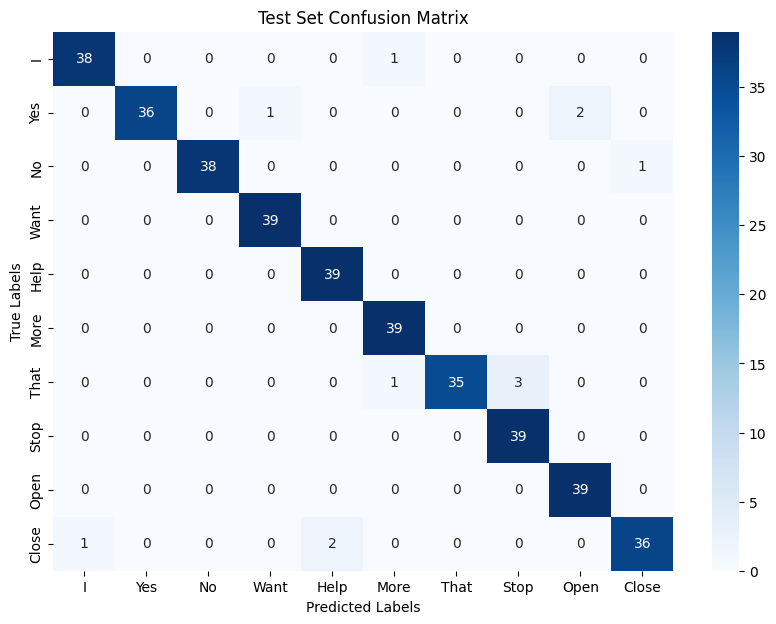

Standard Deviation: 2.8515

ROC Curve and AUC Scores: 


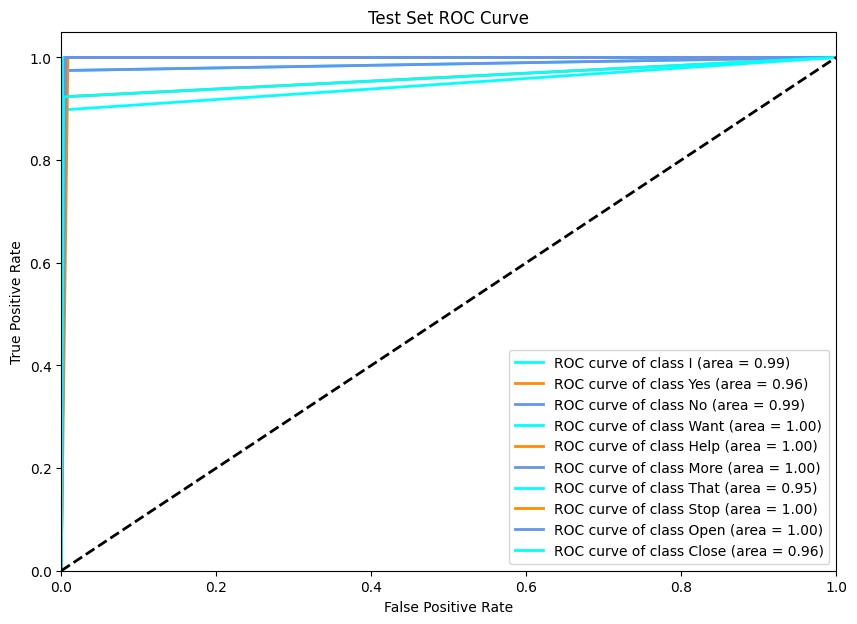

Precision-Recall Curve: 


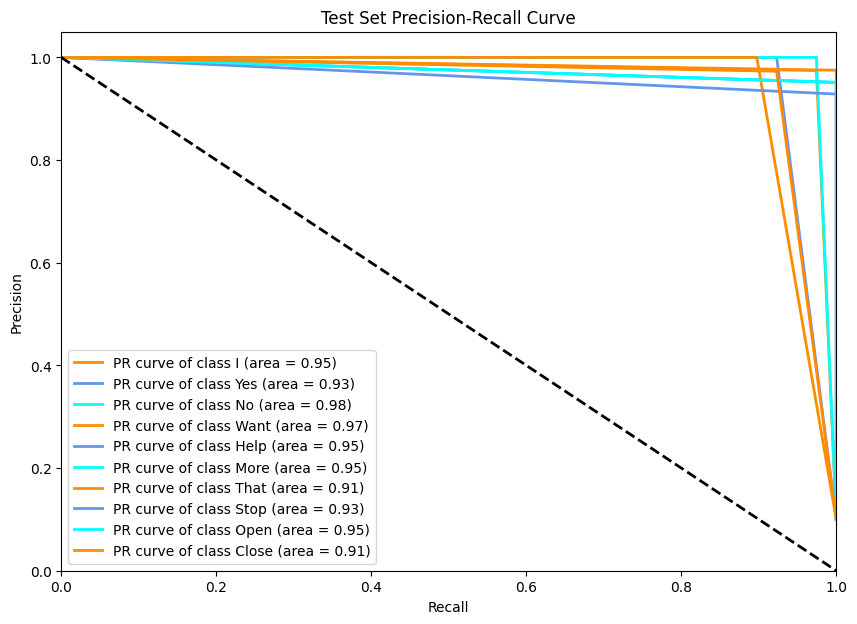

In [35]:
# Calculate metrics for the Testing Set:

model.eval()
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        output = model(features)
        predictions = torch.max(output, 1)[1]
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predictions.cpu().numpy())

# Calculate and display metrics for the test set
calculate_metrics(all_test_labels, all_test_preds, dataset_name = 'Test Set')

In [37]:
# Real-time Predictions:

def predict(model, input_data, device):
    model.eval()
    input_data = torch.tensor(input_data, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(input_data)
        _, predicted = torch.max(output.data, 1)
    return predicted.cpu().numpy()

# Load the trained model weights
model.load_state_dict(torch.load('Phase_1/Final_Models/Transformer_Model.pth'))

# Ensure the LabelEncoder is fitted with all possible labels
# Assuming train_labels contains all possible labels
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

# Debug: Print the classes known to the LabelEncoder
print("Classes known to LabelEncoder:", label_encoder.classes_)

# Example usage
sample_inputs = test_features[:10]  # Take five samples from the test set
actual_labels = test_labels[:10]

# Encode the actual_labels if they are not already encoded
encoded_actual_labels = label_encoder.transform(actual_labels)

predicted_labels = predict(model, sample_inputs, device)

# Debug: Print actual and predicted labels before decoding
print("Encoded actual labels before decoding:", encoded_actual_labels)
print("Predicted labels before decoding:", predicted_labels)

# Decode actual and predicted labels
try:
    decoded_actual_labels = label_encoder.inverse_transform(encoded_actual_labels)
    decoded_predicted_labels = label_encoder.inverse_transform(predicted_labels)
    
    # Debug: Print actual and predicted labels after transformation
    print("Decoded Actual labels:", decoded_actual_labels)
    print("Decoded Predicted labels:", decoded_predicted_labels)

    # Print actual vs predicted labels
    for actual, predicted in zip(decoded_actual_labels, decoded_predicted_labels):
        print(f'Actual: {actual}, Predicted: {predicted}')
except ValueError as e:
    print(f"Error during label decoding: {e}")
    print("This might be due to unseen labels in the predicted labels.")
    print("Encoded actual labels:", encoded_actual_labels)
    print("Predicted labels:", predicted_labels)


Classes known to LabelEncoder: ['Close' 'Help' 'I' 'More' 'No' 'Open' 'Stop' 'That' 'Want' 'Yes']
Encoded actual labels before decoding: [6 7 5 9 7 6 5 0 3 7]
Predicted labels before decoding: [6 7 5 9 7 5 5 0 3 7]
Decoded Actual labels: ['Stop' 'That' 'Open' 'Yes' 'That' 'Stop' 'Open' 'Close' 'More' 'That']
Decoded Predicted labels: ['Stop' 'That' 'Open' 'Yes' 'That' 'Open' 'Open' 'Close' 'More' 'That']
Actual: Stop, Predicted: Stop
Actual: That, Predicted: That
Actual: Open, Predicted: Open
Actual: Yes, Predicted: Yes
Actual: That, Predicted: That
Actual: Stop, Predicted: Open
Actual: Open, Predicted: Open
Actual: Close, Predicted: Close
Actual: More, Predicted: More
Actual: That, Predicted: That
